# skFIBERS Datasim Experiments

## Imports

In [1]:
import random
import numpy as np
import pandas as pd
from skfibers.fibers import FIBERS

In [2]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from skfibers.methods.fibers_methods import top_bin_summary_fibers

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

## Functions to Generate Dataset

In [4]:
def generate_features(row, number_of_features, number_of_features_in_bin, mm_frequency_range):
    mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    if row['TrueRiskGroup'] == 1:
        idxs = random.sample(list(range(1, number_of_features_in_bin + 1)), 
                             int(mm_frequency * number_of_features_in_bin))
        for idx in idxs:
            row['P_' + str(idx)] = 1
        idxs = random.sample(list(range(1, number_of_features - number_of_features_in_bin + 1)), 
                             int(mm_frequency * (number_of_features - number_of_features_in_bin)))
        for idx in idxs:
            row['R_' + str(idx)] = 1
    else:
        idxs = random.sample(list(range(1, number_of_features - number_of_features_in_bin + 1)), 
                             int(mm_frequency * (number_of_features - number_of_features_in_bin)))
        for idx in idxs:
            row['R_' + str(idx)] = 1
    return row

In [5]:
def censor(df, censoring_frequency):
#     df['Censoring'] = df['TrueRiskGroup']
    df['Censoring'] = 1
    inst_to_censor = int(censoring_frequency * len(df)) # len(df[df['TrueRiskGroup']==1]))
    max_duration = max(df['Duration'])
    df = df.sort_values('Duration')
    censor_count = 0
    while censor_count < inst_to_censor:
        for index in range(len(df)):
            prob = df['Duration'].iloc[index]/max_duration
            choice = np.random.choice([0, 1], 1, p=[prob, 1-prob])
            if choice == 0:
                censor_count +=1
                df['Censoring'].iloc[index] = choice
            if censor_count >= inst_to_censor:
                break
    return df

In [6]:
def create_data_simulation_bin(number_of_instances, number_of_features, number_of_features_in_bin,
                               no_fail_proportion, mm_frequency_range, noise_frequency,
                               class0_time_to_event_range, class1_time_to_event_range, censoring_frequency):
    """
    Defining a function to create an artificial dataset with parameters, there will be one ideal/strong bin
    Note: MAF (minor allele frequency) cutoff refers to the threshold
    separating rare variant features from common features

    :param number_of_instances: dataset size
    :param number_of_features: total number of features in dataset
    :param number_of_features_in_bin: total number of predictive features in the ideal bin
    :param no_fail_proportion: the proportion of instances to be labled as (no fail class)
    :param mm_frequency_range: the max and min MM frequency for a given column/feature in data. (e.g. 0.1 to 0.5)
    :param noise_frequency: Value from 0 to 0.5 representing the proportion of class 0/class 1 instance pairs that \
                            have their outcome switched from 0 to 1
    :param class0_time_to_event_range: (min, max) time to event as a tuple (should be larger (e.g. 100 to 200)
    :param class1_time_to_event_range: (min, max) time to event as a tuple (should be smaller but a but overlapping \
                                        with above range (e.g. 20 to 150)

    :return: pandas dataframe of generated data
    """
    
    # Creating an empty dataframe to use as a starting point for the eventual feature matrix
    # Adding one to number of features to give space for the class and Duration column
    df = pd.DataFrame(np.zeros((number_of_instances, number_of_features + 2)))
    
    # Creating a list of predictive features in the strong bin
    predictive_features = ["P_" + str(i + 1) for i in range(number_of_features_in_bin)]

    # Creating a list of randomly created features
    random_features = ["R_" + str(i + 1) for i in range(number_of_features - number_of_features_in_bin)]

    # Adding the features and the class/endpoint
    df.columns  = predictive_features + random_features + ['TrueRiskGroup', 'Duration']
    
    # Assigning class according to no_fail_proportion parameter
    fail_count = int(number_of_instances * (1 - no_fail_proportion))
    no_fail_count = number_of_instances - fail_count
    class_list = [1] * fail_count + [0] * no_fail_count
    df['TrueRiskGroup'] = class_list
    
    # Generating predictive and random features columns
#     mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    df = df.apply(generate_features, 
                  args=(number_of_features, number_of_features_in_bin, 
                        mm_frequency_range), axis=1).astype(int)
    
    # Assigning Guassians according to class
    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    df_0['Duration'] = np.clip(np.random.normal(class0_time_to_event_range[0], 
                                         class0_time_to_event_range[1], size=len(df_0)), 
                               a_min = 0, a_max=None)
    df_1['Duration'] = np.clip(np.random.normal(class1_time_to_event_range[0], 
                                         class1_time_to_event_range[1], size=len(df_1)), 
                               a_min = 0, a_max=None)
    df = censor(pd.concat([df_0, df_1]), censoring_frequency)
    
    df_0 = df[df['Censoring'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['Censoring'] == 1].sample(frac=1).reset_index(drop=True)
    if noise_frequency > 0:
        swap_count = int(min(len(df_0), len(df_1)) * noise_frequency)
        idxs = random.sample(list(range(min(len(df_0), len(df_1)))), swap_count)
        for i in idxs:
            df_0['Censoring'].iloc[i], df_1['Censoring'].iloc[i] = \
            df_1['Censoring'].iloc[i].copy(), df_0['Censoring'].iloc[i].copy()
            df_0['Duration'].iloc[i], df_1['Duration'].iloc[i] = \
            df_1['Duration'].iloc[i].copy(), df_0['Duration'].iloc[i].copy()
    
    df = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True)
    return df

In [7]:
def create_negative_control(number_of_instances, number_of_features, number_of_features_in_bin,
                               no_fail_proportion, mm_frequency_range, noise_frequency,
                               class0_time_to_event_range, class1_time_to_event_range, censoring_frequency):
    """
    Defining a function to create an artificial dataset with parameters, there will be one ideal/strong bin
    Note: MAF (minor allele frequency) cutoff refers to the threshold
    separating rare variant features from common features

    :param number_of_instances: dataset size
    :param number_of_features: total number of features in dataset
    :param number_of_features_in_bin: total number of predictive features in the ideal bin
    :param no_fail_proportion: the proportion of instances to be labled as (no fail class)
    :param mm_frequency_range: the max and min MM frequency for a given column/feature in data. (e.g. 0.1 to 0.5)
    :param noise_frequency: Value from 0 to 0.5 representing the proportion of class 0/class 1 instance pairs that \
                            have their outcome switched from 0 to 1
    :param class0_time_to_event_range: (min, max) time to event as a tuple (should be larger (e.g. 100 to 200)
    :param class1_time_to_event_range: (min, max) time to event as a tuple (should be smaller but a but overlapping \
                                        with above range (e.g. 20 to 150)

    :return: pandas dataframe of generated data
    """
    
    # Creating an empty dataframe to use as a starting point for the eventual feature matrix
    # Adding one to number of features to give space for the class and Duration column
    df = pd.DataFrame(np.zeros((number_of_instances, number_of_features + 2)))
    
    # Creating a list of predictive features in the strong bin
    predictive_features = ["P_" + str(i + 1) for i in range(number_of_features_in_bin)]

    # Creating a list of randomly created features
    random_features = ["R_" + str(i + 1) for i in range(number_of_features - number_of_features_in_bin)]

    # Adding the features and the class/endpoint
    df.columns  = predictive_features + random_features + ['TrueRiskGroup', 'Duration']
    
    # Assigning class according to no_fail_proportion parameter
    fail_count = int(number_of_instances * (1 - no_fail_proportion))
    no_fail_count = number_of_instances - fail_count
    class_list = [1] * fail_count + [0] * no_fail_count
    df['TrueRiskGroup'] = class_list
    
    # Generating predictive and random features columns
#     mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    df = df.apply(generate_features, 
                  args=(number_of_features, number_of_features_in_bin, 
                        mm_frequency_range), axis=1).astype(int)
    
    # Assigning Guassians according to class
    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    df_0['Duration'] = np.clip(np.random.normal(class0_time_to_event_range[0], 
                                         class0_time_to_event_range[1], size=len(df_0)), 
                               a_min = 0, a_max=None)
    df_1['Duration'] = np.clip(np.random.normal(class1_time_to_event_range[0], 
                                         class1_time_to_event_range[1], size=len(df_1)), 
                               a_min = 0, a_max=None)
    df = censor(pd.concat([df_0, df_1]), censoring_frequency)
    
    df_0 = df[df['Censoring'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['Censoring'] == 1].sample(frac=1).reset_index(drop=True)
    if noise_frequency > 0:
        swap_count = int(min(no_fail_count, fail_count) * noise_frequency)
        idxs = random.sample(list(range(min(no_fail_count, fail_count))), swap_count)
        for i in idxs:
            df_0['Censoring'].iloc[i], df_1['Censoring'].iloc[i] = \
            df_1['Censoring'].iloc[i].copy(), df_0['Censoring'].iloc[i].copy()
            df_0['Duration'].iloc[i], df_1['Duration'].iloc[i] = \
            df_1['Duration'].iloc[i].copy(), df_0['Duration'].iloc[i].copy()
    
    df = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True)
    return df

In [8]:
data = create_data_simulation_bin(number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
               no_fail_proportion=0.8, mm_frequency_range=(0.2, 0.9) , noise_frequency=0,
               class0_time_to_event_range=(0.7, 0.2), class1_time_to_event_range=(1.7, 0.2),
               censoring_frequency=0.5)

In [9]:
data.head(15)

,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,P_10,...,R_34,R_35,R_36,R_37,R_38,R_39,R_40,TrueRiskGroup,Duration,Censoring
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,0,0.571166,0
1,1,0,1,1,1,1,0,0,1,0,...,1,1,0,0,1,1,1,1,1.348399,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0.669071,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,0,0.856597,0
4,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,1,0,1,1.723753,0
5,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,1.025548,1
6,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,1,0,0.417336,1
7,0,1,0,0,1,1,1,1,0,1,...,1,0,1,0,0,0,1,1,1.780705,0
8,1,1,1,0,1,0,0,1,0,1,...,1,1,1,1,1,0,0,1,1.649324,0
9,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,1,1.368409,1


## Functions to Run Experiment

In [10]:
def experiment(number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
               no_fail_proportion=0.8, mm_frequency_range=(0.2, 0.9) , noise_frequency=0,
               class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
               censoring_frequency=0.5, exp_str='1'):
    for replicate in range(0, 1):
        print('Experiment ' + exp_str)
        # Creating the simulated dataset with 1000 instances, 10 features to bin, 50 total features
        # no_fail_proportion=0.5, mm_frequency_range=(0.1, 0.5) , noise_frequency=0,
        # class0_time_to_event_range=(100, 200), class1_time_to_event_range=(20, 150)
        data = create_data_simulation_bin(number_of_instances, number_of_features, number_of_features_in_bin,
                                          no_fail_proportion, mm_frequency_range , noise_frequency,
                                          class0_time_to_event_range, class1_time_to_event_range,
                                          censoring_frequency)
        data = data.drop('TrueRiskGroup', axis=1)
        fibers = FIBERS(given_starting_point=False, amino_acid_start_point=None, algorithm="FIBERS",
                        amino_acid_bins_start_point=None, iterations=100, label_name="Censoring",
                        duration_name="Duration", rare_variant_maf_cutoff=0.2,
                        set_number_of_bins=50, min_features_per_group=2,
                        max_number_of_groups_with_feature=2,
                        scoring_method='Relief',
                        score_based_on_sample=True, score_with_common_variables=False,
                        instance_sample_size=50, crossover_probability=0.8,
                        mutation_probability=0.4, elitism_parameter=0.8,
                        random_seed=None, bin_size_variability_constraint=None)
        fibers.fit(data)
        fibers, bin_feature_matrix_internal, amino_acid_bins_internal, \
            amino_acid_bin_scores_internal, maf_0_features = fibers.transform(data)
        sorted_bin_scores = dict(sorted(amino_acid_bin_scores_internal.items(), key=lambda item: item[1], reverse=True))
        sorted_bin_list = list(sorted_bin_scores.keys())
        sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
        Bin = amino_acid_bins_internal[sorted_bin_list[0]]
        print("Best Bin:", Bin)
    return bin_feature_matrix_internal, amino_acid_bins_internal, \
        amino_acid_bin_scores_internal, maf_0_features

## Functions to plot outputs

In [11]:
def top_bin_summary_edited(original_feature_matrix, label_name, duration_name, bin_feature_matrix, bins, bin_scores):
    
    #Ordering the bin scores from best to worst
    sorted_bin_scores = dict(sorted(bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    
    topbin = sorted_bin_list[0]
    
    df_0 = bin_feature_matrix.loc[bin_feature_matrix[topbin] == 0]
    df_1 = bin_feature_matrix.loc[bin_feature_matrix[topbin] > 0]
        
    durations_no = df_0[duration_name].to_list()        
    event_observed_no = df_0[label_name].to_list()
    durations_mm = df_1[duration_name].to_list()
    event_observed_mm = df_1[label_name].to_list()
        
    results = logrank_test(durations_no, durations_mm, event_observed_A=event_observed_no, event_observed_B=event_observed_mm)
    
    print("Bin of Amino Acid Positions:")
    print(bins[topbin])
    print("---")
    print("Number of Instances with No Mismatches in Bin:")
    print(len(durations_no))
    print("Number of Instances with Mismatch(es) in Bin:")
    print(len(durations_mm))
    print("---")
    print("p-value from Log Rank Test:")
    print(results.p_value)
    results.print_summary()
    kmf1 = KaplanMeierFitter() 

    ## fit the model for 1st cohort
    kmf1.fit(durations_no, event_observed_no, label='No Mismatches in Bin')
    a1 = kmf1.plot()
    a1.set_ylabel('Survival Probability')

    ## fit the model for 2nd cohort
    kmf1.fit(durations_mm, event_observed_mm, label='Mismatch(es) in Bin')
    kmf1.plot(ax=a1)
    a1.set_xlabel('Years After Transplant')
    plt.show()

In [12]:
def score_df(amino_acid_bin_scores_internal, amino_acid_bins_internal):
    amino_acid_bin_scores_internal_sorted = sorted(amino_acid_bin_scores_internal.items(), 
                                                   key=lambda x:x[1], reverse=True)
    amino_acid_bins_internal_sorted = sorted(amino_acid_bins_internal.items(), 
                                             key=lambda x:len(x[1]), reverse=True)
    tdf1 = pd.DataFrame(amino_acid_bin_scores_internal_sorted, columns=['Bin #', 'Score'])
    tdf2 = pd.DataFrame(amino_acid_bins_internal_sorted, columns=['Bin #', 'Bins'])
    tdf3 = tdf1.merge(tdf2, on='Bin #', how='inner', suffixes=('_1', '_2'))
    display(tdf3.head(10).T)

## Testing Functions

In [13]:
bin_feature_matrix, amino_acid_bins, \
            amino_acid_bin_scores, maf_0_features = experiment(
                number_of_instances=10000, number_of_features=50, number_of_features_in_bin=10,
                no_fail_proportion=0.5, mm_frequency_range=(0.3, 0.4) , noise_frequency=0,
                class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
                censoring_frequency=0.8)

Experiment 1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


Best Bin: ['P_9', 'P_10', 'P_8', 'P_7', 'P_2', 'P_1', 'P_5']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 34,Bin 19,Bin 31,Bin 4,Bin 5,Bin 3,Bin 30,Bin 38,Bin 37,Bin 35
Score,5628.354434,4319.440108,4187.363739,3508.963156,3452.261262,3385.617866,3382.853864,3375.503373,3249.467396,2533.132461
Bins,"[P_9, P_10, P_8, P_7, P_2, P_1, P_5]","[P_9, P_3, P_6, P_1]","[P_8, P_4, P_7, P_9]","[P_7, P_2, P_1]","[P_5, P_1, P_8]","[P_10, P_2, P_3]","[P_8, P_9, P_6]","[P_8, P_10, P_7]","[P_9, P_7, P_5]","[P_6, P_3]"


Bin of Amino Acid Positions:
['P_9', 'P_10', 'P_8', 'P_7', 'P_2', 'P_1', 'P_5']
---
Number of Instances with No Mismatches in Bin:
5047
Number of Instances with Mismatch(es) in Bin:
4953
---
p-value from Log Rank Test:
0.0


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        5628.35 <0.005       inf

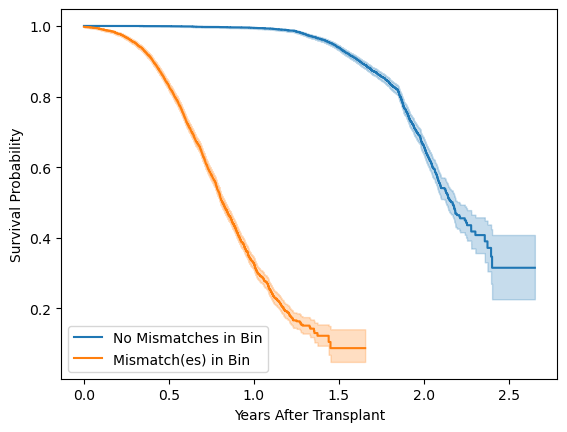

In [14]:
score_df(amino_acid_bin_scores, amino_acid_bins)
top_bin_summary_edited(pd.DataFrame(), "Censoring", "Duration", bin_feature_matrix, amino_acid_bins,
                           amino_acid_bin_scores)

Experiment MM Freq Range=(0.1, 0.3), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:35<00:00,  1.04it/s]


Best Bin: ['R_39', 'P_4', 'P_1', 'P_7', 'P_3']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 9,Bin 24,Bin 8,Bin 30,Bin 37,Bin 22,Bin 26,Bin 21,Bin 32,Bin 38
Score,413.40227,358.911734,352.447285,350.952126,350.952126,339.152404,320.324243,305.927225,278.68369,254.797006
Bins,"[R_39, P_4, P_1, P_7, P_3]","[P_2, P_8, P_6, P_1, R_16]","[P_2, P_3, P_1, R_32, P_8]","[P_9, P_3, P_6, R_11, P_2]","[P_2, P_9, P_3, P_6, R_11]","[P_5, P_3, P_6, P_1, R_3]","[P_2, P_9, P_6, P_1, R_2]","[P_2, R_1, P_8, P_1, P_7, R_4, P_4]","[P_8, P_6, P_1, R_26]","[P_2, R_27, P_9, P_10, P_6, P_5, R_35]"


Bin of Amino Acid Positions:
['R_39', 'P_4', 'P_1', 'P_7', 'P_3']
---
Number of Instances with No Mismatches in Bin:
7264
Number of Instances with Mismatch(es) in Bin:
2736
---
p-value from Log Rank Test:
6.661115225718816e-92


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         413.40 <0.005    302.88

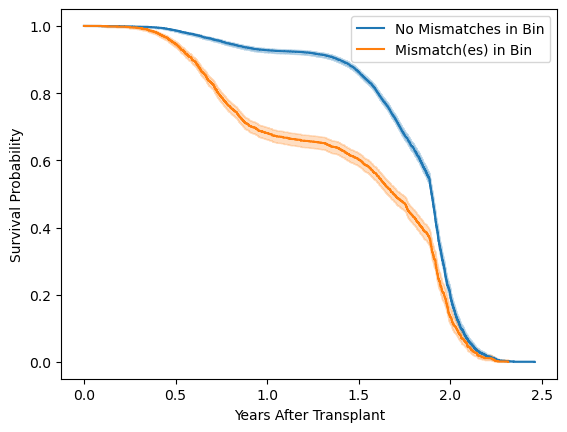

Experiment MM Freq Range=(0.2, 0.4), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Best Bin: ['P_9', 'P_10', 'P_6', 'P_1', 'R_9']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 12,Bin 20,Bin 19,Bin 17,Bin 38,Bin 9,Bin 15,Bin 28,Bin 23,Bin 34
Score,538.524884,514.136995,488.279883,444.252863,420.424023,370.097468,343.174638,316.329381,315.595828,309.455751
Bins,"[P_9, P_10, P_6, P_1, R_9]","[P_5, P_8, P_6, P_1, P_7, R_30]","[P_9, R_39, P_10, P_4, P_1]","[P_9, P_10, P_6, P_1, P_2, R_6]","[P_9, P_10, P_3, P_6, R_4]","[P_2, P_6, R_37, P_5]","[P_2, R_28, P_1, P_9]","[P_8, P_4, P_6, R_29]","[P_2, P_8, R_29, P_3]","[P_2, P_10, R_35, P_3]"


Bin of Amino Acid Positions:
['P_9', 'P_10', 'P_6', 'P_1', 'R_9']
---
Number of Instances with No Mismatches in Bin:
6123
Number of Instances with Mismatch(es) in Bin:
3877
---
p-value from Log Rank Test:
3.9476784085809224e-119


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         538.52 <0.005    393.33

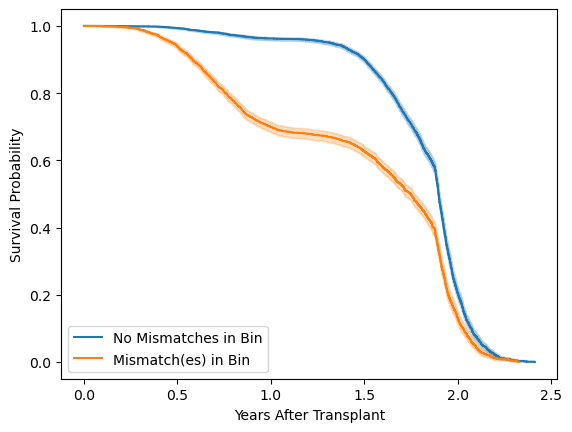

Experiment MM Freq Range=(0.3, 0.5), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Best Bin: ['P_2', 'P_9', 'P_10', 'P_1', 'P_6', 'R_1']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 37,Bin 34,Bin 38,Bin 22,Bin 1,Bin 9,Bin 13,Bin 43,Bin 11,Bin 29
Score,461.912207,454.093379,437.231737,365.179404,341.718257,334.647909,334.647909,326.565168,322.092533,322.092533
Bins,"[P_2, P_9, P_10, P_1, P_6, R_1]","[R_1, P_3, P_8, P_1, P_2, P_9]","[R_27, P_10, P_3, P_8, P_7, P_6]","[P_9, P_8, P_6, R_33]","[P_2, P_10, P_1, R_37]","[P_10, P_1, P_3, R_33]","[P_3, P_10, R_33, P_1]","[P_3, P_10, P_1, R_19]","[R_1, P_2, P_7, P_8]","[P_2, P_8, P_7, R_1]"


Bin of Amino Acid Positions:
['P_2', 'P_9', 'P_10', 'P_1', 'P_6', 'R_1']
---
Number of Instances with No Mismatches in Bin:
4979
Number of Instances with Mismatch(es) in Bin:
5021
---
p-value from Log Rank Test:
1.844012718219066e-102


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         461.91 <0.005    337.95

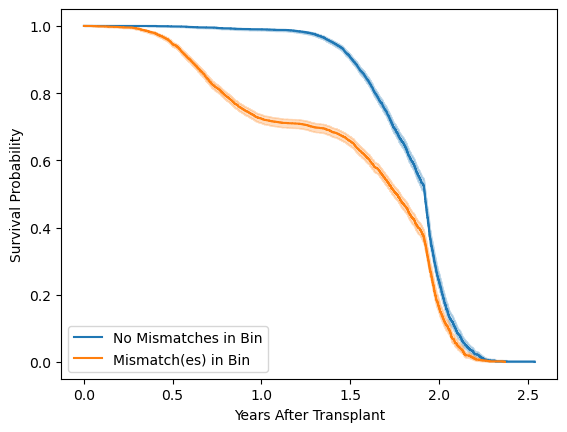

Experiment MM Freq Range=(0.4, 0.6), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Best Bin: ['P_2', 'P_9', 'P_1', 'R_38', 'P_3']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 7,Bin 8,Bin 30,Bin 12,Bin 11,Bin 34,Bin 40,Bin 28,Bin 31,Bin 35
Score,322.697167,315.077404,314.37124,309.032143,300.698142,296.70752,295.376762,282.183933,280.354414,274.087041
Bins,"[P_2, P_9, P_1, R_38, P_3]","[P_3, P_8, R_29, P_1, P_2]","[P_2, P_10, P_1, P_7, R_27, P_9]","[P_2, P_3, P_1, R_15, P_4]","[P_9, P_10, P_3, P_6, P_1, R_35, P_7]","[P_2, P_3, P_7, R_30, P_6]","[P_3, P_1, P_10, R_30, P_5]","[P_2, P_8, P_1, R_26]","[P_2, P_10, P_8, R_15]","[P_2, P_3, P_8, P_6, R_17]"


Bin of Amino Acid Positions:
['P_2', 'P_9', 'P_1', 'R_38', 'P_3']
---
Number of Instances with No Mismatches in Bin:
4210
Number of Instances with Mismatch(es) in Bin:
5790
---
p-value from Log Rank Test:
3.744617392360822e-72


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         322.70 <0.005    237.27

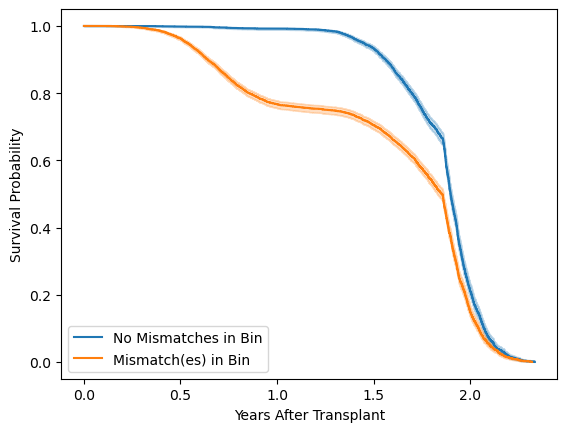

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


Best Bin: ['P_5', 'R_2', 'P_8', 'P_1', 'P_1', 'P_3']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 1,Bin 47,Bin 7,Bin 26,Bin 38,Bin 10,Bin 13,Bin 14,Bin 6,Bin 40
Score,263.661311,261.798304,246.044224,233.163775,232.031111,226.086531,225.398157,223.78471,223.53853,222.079489
Bins,"[P_5, R_2, P_8, P_1, P_1, P_3]","[P_10, P_1, R_2, P_8, P_4]","[P_8, R_16, P_9, P_6, P_1]","[P_10, P_5, P_3, P_1, P_4, R_24]","[P_5, P_3, P_6, P_1, R_5]","[P_10, P_8, P_4, P_6, R_15]","[P_3, P_1, R_1, P_10, P_7]","[R_22, P_5, P_10, P_3]","[P_8, R_16, P_6, P_9]","[P_10, P_3, P_7, R_22]"


Bin of Amino Acid Positions:
['P_5', 'R_2', 'P_8', 'P_1', 'P_1', 'P_3']
---
Number of Instances with No Mismatches in Bin:
3259
Number of Instances with Mismatch(es) in Bin:
6741
---
p-value from Log Rank Test:
2.731862615608892e-59


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         263.66 <0.005    194.54

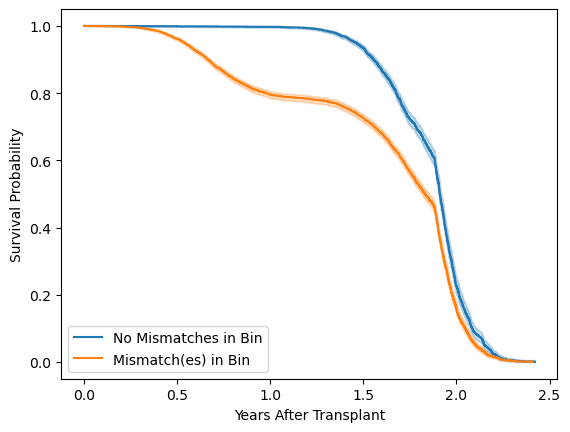

Experiment MM Freq Range=(0.6, 0.8), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Best Bin: ['P_2', 'P_6', 'R_18', 'P_9', 'P_5']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 14,Bin 31,Bin 40,Bin 38,Bin 34,Bin 29,Bin 25,Bin 8,Bin 4,Bin 19
Score,159.78339,159.78339,158.94937,157.002415,155.360556,153.375051,153.187868,150.359907,149.264268,147.343266
Bins,"[P_2, P_6, R_18, P_9, P_5]","[P_6, P_1, P_7, P_5, P_4, R_18]","[P_10, P_5, P_4, P_6, R_7]","[P_2, P_9, P_5, P_1, R_34]","[P_2, P_1, P_9, R_7]","[P_2, P_10, R_11]","[P_2, P_1, R_11]","[P_1, P_8, R_33]","[P_6, P_5, P_10, R_7]","[P_5, P_6, P_1, R_5, P_8, P_7]"


Bin of Amino Acid Positions:
['P_2', 'P_6', 'R_18', 'P_9', 'P_5']
---
Number of Instances with No Mismatches in Bin:
2476
Number of Instances with Mismatch(es) in Bin:
7524
---
p-value from Log Rank Test:
1.2617553292700166e-36


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         159.78 <0.005    119.25

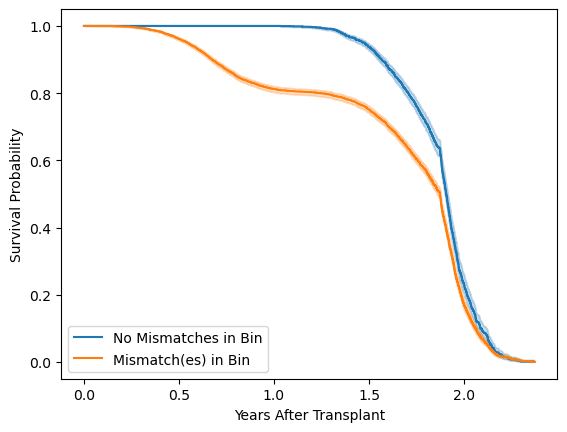

In [15]:
for i in range(1, 7):
    j=5
    bin_feature_matrix, amino_acid_bins, \
            amino_acid_bin_scores, maf_0_features = experiment(
        mm_frequency_range=(i/10, (i+2)/10) , 
        censoring_frequency=j/10, 
        exp_str="MM Freq Range=" + str((i/10, (i+2)/10)) + ", Censoring Freq="+str(j/10)
    )
    score_df(amino_acid_bin_scores, amino_acid_bins)
    top_bin_summary_edited(pd.DataFrame(), "Censoring", "Duration", bin_feature_matrix, amino_acid_bins,
                           amino_acid_bin_scores)

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.1
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


Best Bin: ['P_10', 'P_3', 'P_2', 'R_3', 'P_7']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 15,Bin 38,Bin 20,Bin 8,Bin 16,Bin 26,Bin 22,Bin 47,Bin 4,Bin 32
Score,169.378253,159.631343,153.506262,133.81887,132.942851,131.308981,129.916338,129.916338,128.12275,127.796009
Bins,"[P_10, P_3, P_2, R_3, P_7]","[P_4, P_1, P_7, R_3]","[P_2, P_8, P_5, R_3]","[P_2, P_5, P_1, P_7, R_29, P_10]","[P_2, P_4, P_7, R_22]","[P_2, P_7, R_34, P_1]","[R_3, P_10, P_7]","[R_3, P_7, P_10]","[P_2, P_1, R_32]","[P_2, R_34, P_8, P_1]"


Bin of Amino Acid Positions:
['P_10', 'P_3', 'P_2', 'R_3', 'P_7']
---
Number of Instances with No Mismatches in Bin:
3304
Number of Instances with Mismatch(es) in Bin:
6696
---
p-value from Log Rank Test:
1.0114949072097135e-38


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         169.38 <0.005    126.22

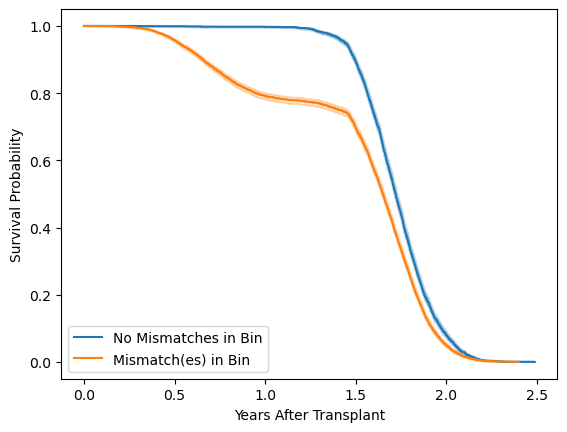

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.3
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


Best Bin: ['P_4', 'R_13', 'P_5', 'P_1']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 35,Bin 22,Bin 11,Bin 4,Bin 37,Bin 20,Bin 30,Bin 9,Bin 8,Bin 16
Score,194.768649,166.819484,158.26531,156.632422,155.720817,153.907483,152.977138,149.42931,142.903822,138.418947
Bins,"[P_4, R_13, P_5, P_1]","[R_3, P_5, P_1, P_9]","[P_10, P_3, R_16, P_6, P_2, P_1]","[P_4, R_1, P_1, P_5]","[P_9, P_10, P_6, R_2]","[P_2, P_5, P_3, R_2]","[P_7, P_4, R_13]","[R_13, P_5, P_3]","[P_2, P_8, R_3]","[P_9, R_28, P_2]"


Bin of Amino Acid Positions:
['P_4', 'R_13', 'P_5', 'P_1']
---
Number of Instances with No Mismatches in Bin:
3334
Number of Instances with Mismatch(es) in Bin:
6666
---
p-value from Log Rank Test:
2.8940360110827153e-44


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         194.77 <0.005    144.63

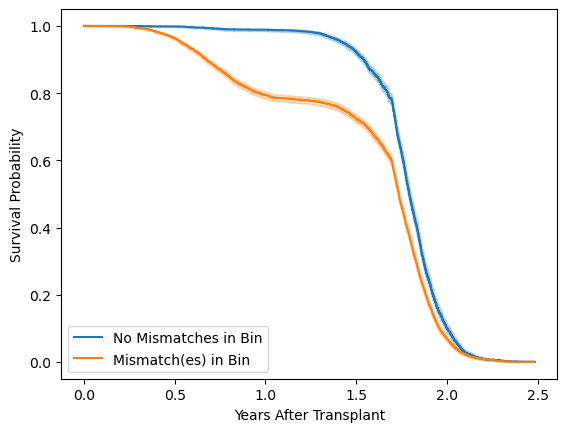

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.5
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


Best Bin: ['P_2', 'P_9', 'P_8', 'R_6', 'P_3']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 2,Bin 28,Bin 13,Bin 31,Bin 43,Bin 23,Bin 26,Bin 37,Bin 18,Bin 15
Score,268.034878,253.674177,228.932034,228.058057,227.563492,224.287934,219.505687,215.254707,210.759882,210.506879
Bins,"[P_2, P_9, P_8, R_6, P_3]","[P_5, P_3, P_8, P_7, R_38]","[P_8, P_2, P_9, R_38]","[P_8, P_9, P_6, P_7, R_15, P_10]","[P_8, P_1, R_8, P_2]","[P_5, P_8, P_4, P_6, R_15]","[P_2, P_8, P_1, R_17]","[P_8, P_9, P_10, P_4, P_3, R_39]","[R_28, P_1, P_6, P_7, P_9]","[P_8, P_3, P_7, R_37]"


Bin of Amino Acid Positions:
['P_2', 'P_9', 'P_8', 'R_6', 'P_3']
---
Number of Instances with No Mismatches in Bin:
3309
Number of Instances with Mismatch(es) in Bin:
6691
---
p-value from Log Rank Test:
3.0423194053167894e-60


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         268.03 <0.005    197.71

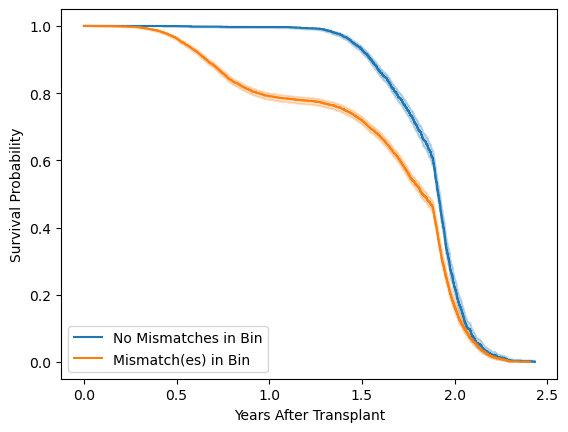

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.7
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Best Bin: ['P_2', 'P_6', 'P_7', 'R_14', 'P_10', 'P_9']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 25,Bin 6,Bin 12,Bin 9,Bin 17,Bin 14,Bin 40,Bin 15,Bin 1,Bin 16
Score,225.336039,192.634395,192.554997,187.296883,186.918634,184.047732,183.523214,172.977051,172.556016,170.989831
Bins,"[P_2, P_6, P_7, R_14, P_10, P_9]","[P_4, P_7, R_2, P_6, P_2]","[P_8, P_7, P_9, R_21]","[P_9, P_8, P_1, P_7, P_6, R_39]","[P_10, P_3, P_6, P_2, R_20]","[P_9, R_39, P_10, P_1, P_7]","[P_5, P_3, P_7, R_4]","[P_2, P_3, R_17]","[P_10, P_7, R_20, P_4]","[P_3, R_14, P_9]"


Bin of Amino Acid Positions:
['P_2', 'P_6', 'P_7', 'R_14', 'P_10', 'P_9']
---
Number of Instances with No Mismatches in Bin:
3353
Number of Instances with Mismatch(es) in Bin:
6647
---
p-value from Log Rank Test:
6.201821938872187e-51


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         225.34 <0.005    166.79

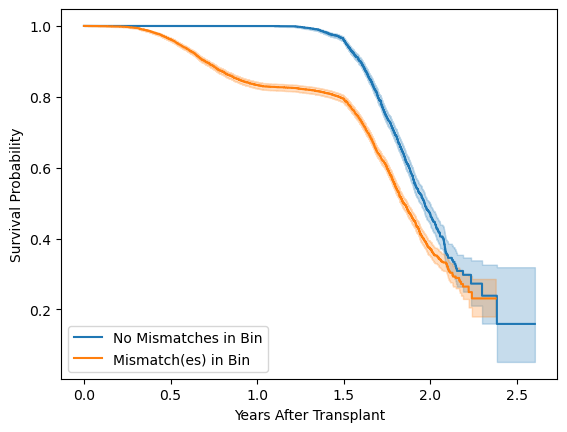

Experiment MM Freq Range=(0.5, 0.7), Censoring Freq=0.9
FIBERS


100%|█████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


Best Bin: ['P_2', 'P_4', 'P_6', 'R_40', 'P_10']


,0,1,2,3,4,5,6,7,8,9
Bin #,Bin 39,Bin 34,Bin 23,Bin 40,Bin 1,Bin 19,Bin 26,Bin 21,Bin 17,Bin 12
Score,208.027673,199.121248,198.389128,191.501746,182.320964,181.323579,180.787764,179.611193,175.689198,173.554499
Bins,"[P_2, P_4, P_6, R_40, P_10]","[P_5, R_32, P_3, P_4]","[P_3, P_6, R_36, P_1]","[P_4, R_35, P_1, P_2]","[R_20, P_1, P_4]","[P_9, R_12, P_5]","[R_20, P_10, P_8]","[R_20, P_10, P_1]","[P_6, P_5, R_20]","[P_3, P_4, R_10]"


Bin of Amino Acid Positions:
['P_2', 'P_4', 'P_6', 'R_40', 'P_10']
---
Number of Instances with No Mismatches in Bin:
3333
Number of Instances with Mismatch(es) in Bin:
6667
---
p-value from Log Rank Test:
3.6998248614102926e-47


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         208.03 <0.005    154.24

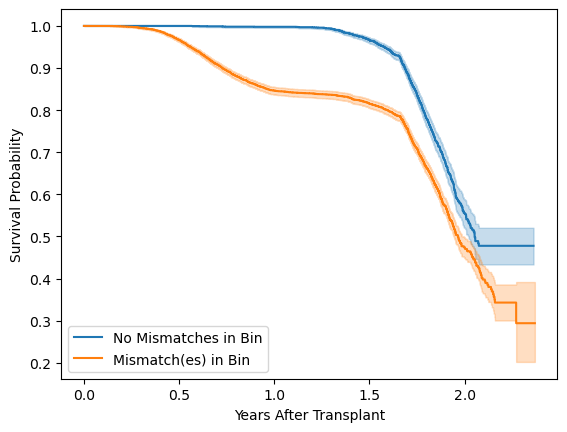

In [16]:
i = 5
for j in range(1, 10, 2):
    bin_feature_matrix, amino_acid_bins, \
            amino_acid_bin_scores, maf_0_features = experiment(
        mm_frequency_range=(i/10, (i+2)/10) , 
        censoring_frequency=j/10, 
        exp_str="MM Freq Range=" + str((i/10, (i+2)/10)) + ", Censoring Freq="+str(j/10)
    )
    score_df(amino_acid_bin_scores, amino_acid_bins)
    top_bin_summary_edited(pd.DataFrame(), "Censoring", "Duration", bin_feature_matrix, amino_acid_bins,
                           amino_acid_bin_scores)